In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# --- 1. 計算関数の定義 ---

def compute_aa_and_aia(acc_matrix: list[list[float]]) -> tuple[list[float], list[float]]:
    """AA_kとAIA_kをそれぞれ計算する。"""
    AA_list = []
    AIA_list = []
    for k in range(len(acc_matrix)):
        current_accs = acc_matrix[k][:k+1]
        AA_k = sum(current_accs) / len(current_accs)
        AA_list.append(AA_k)
        AIA_k = sum(AA_list) / len(AA_list)
        AIA_list.append(AIA_k)
    return AA_list, AIA_list

def compute_fm(acc_matrix: list[list[float]]) -> list[float]:
    """Forgetting Measure (FM_k) を計算する。"""
    num_tasks = len(acc_matrix)
    if num_tasks == 0:
        return []
        
    fm_list = [0.0]  # Task 0 終了時点では忘却は発生しないので0
    
    for k in range(1, num_tasks):
        forgetting_sum = 0.0
        for j in range(k):
            # Task j に対する過去の最高精度を計算 (l < k)
            past_accs_on_j = [acc_matrix[l][j] for l in range(j, k)]
            max_past_acc = max(past_accs_on_j)
            
            # 現在のTask jに対する精度
            current_acc = acc_matrix[k][j]
            
            # 忘却量を計算し、合計に加える
            forgetting_sum += (max_past_acc - current_acc)
            
        # Task k 終了時点での平均忘却量を計算
        avg_forgetting = forgetting_sum / k
        fm_list.append(avg_forgetting)
        
    return fm_list

def compute_im(acc_matrix: list[list[float]], joint_accs: list[float]) -> list[float]:
    """
    Intransigence Measure (IM_k) を計算する
    """
    num_tasks = len(acc_matrix)
    im_list = []

    for k in range(num_tasks):
        if k >= len(joint_accs):
            break
        a_k_star = joint_accs[k]         # 合同学習精度
        a_k_k = acc_matrix[k][k]         # 継続学習でタスクk学習直後の精度
        im_list.append(a_k_star - a_k_k) # 差を計算

    return im_list

# --- 2. 設定 ---

csv_directory = "/work/csv/uci-har/dil_noise-finetune/"
csv_directory_im = "/work/csv/uci-har/dil_noise-finetune/im/"
models_to_process = {
    "RNN": "rnn.csv",
    "CNN": "cnn.csv",
    "LSTM": "lstm.csv",
    "NCP": "ltc_ncps.csv"
}
tasks = [
  (6,0.0),
  (6,0.1),
  (6,0.2),
  (6,0.3),
  (6,0.4),
  (6,0.5),
  (6,0.6),
  (6,0.7),
  (6,0.8),
  (6,0.9),
  (6,1.0)
]
num_tasks = len(tasks)
color_palette = {
    "CNN": "blue",
    "RNN": "green",
    "LSTM": "orange",
    "NCP": "red"
}

# --- 3. データ処理と全指標の計算 ---

all_metrics_results = []
for model_name, file_name in models_to_process.items():
    file_path = os.path.join(csv_directory, file_name)
    if not os.path.exists(file_path):
        print(f"警告: ファイルが見つかりません: {file_path}")
        continue
        
    print(f"\n--- Processing model: {model_name} ---")
    df = pd.read_csv(file_path)
    accuracies = df['テスト精度 (Test Acc)'].tolist()
    
    acc_matrix = []

    # im用
    joint_file_path = os.path.join(csv_directory_im, file_name)
    if not os.path.exists(joint_file_path):
        print(f"警告: Jointファイルが見つかりません: {joint_file_path}")
        continue
    joint_df = pd.read_csv(joint_file_path)
    joint_accuracies = joint_df['テスト精度 (Test Acc)'].tolist()

    current_pos = 0
    for k in range(num_tasks):
        num_evals = k + 1
        if current_pos + num_evals > len(accuracies):
            print(f"エラー: {model_name} のデータ数が不足しています。")
            break
        row = accuracies[current_pos : current_pos + num_evals]
        acc_matrix.append(row)
        current_pos += num_evals

    if not acc_matrix:
        continue

    # AA, AIA, FM, IM を計算
    aa_list, aia_list = compute_aa_and_aia(acc_matrix)
    fm_list = compute_fm(acc_matrix)
    im_list = compute_im(acc_matrix, joint_accuracies)
    
    for k in range(len(aa_list)):
        all_metrics_results.append({
            "Model": model_name,
            "Task": k,
            "Noise": tasks[k][1],
            "AA": aa_list[k],
            "AIA": aia_list[k],
            "FM": fm_list[k],
            "IM": im_list[k],
            "Task 0 Acc": acc_matrix[k][0] 
        })

metrics_df = pd.DataFrame(all_metrics_results)
print("\n--- Calculated Metrics (AA, AIA, FM, IM) ---")
print(metrics_df)


--- Processing model: RNN ---

--- Processing model: CNN ---

--- Processing model: LSTM ---

--- Processing model: NCP ---

--- Calculated Metrics (AA, AIA, FM, IM) ---
   Model  Task  Noise        AA       AIA        FM        IM  Task 0 Acc
0    RNN     0    0.0  0.899286  0.899286  0.000000  0.001429    0.899286
1    RNN     1    0.1  0.877857  0.888571  0.024643  0.022377    0.874643
2    RNN     2    0.2  0.882500  0.886548  0.011607  0.021575    0.875000
3    RNN     3    0.3  0.893482  0.888281  0.000357  0.014113    0.883571
4    RNN     4    0.4  0.891071  0.888839  0.008393  0.012906    0.882857
5    RNN     5    0.5  0.891310  0.889251  0.008000  0.002549    0.879286
6    RNN     6    0.6  0.892653  0.889737  0.008631 -0.009830    0.870357
7    RNN     7    0.7  0.886473  0.889329  0.017755  0.005223    0.868214
8    RNN     8    0.8  0.893214  0.889761  0.010848 -0.004188    0.872500
9    RNN     9    0.9  0.885893  0.889374  0.020119 -0.015170    0.861786
10   RNN    10 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# --- 1. 計算関数 ---
def compute_aa_and_aia(acc_matrix: list[list[float]]) -> tuple[list[float], list[float]]:
    AA_list, AIA_list = [], []
    for k in range(len(acc_matrix)):
        current_accs = acc_matrix[k][:k+1]
        AA_k = sum(current_accs) / len(current_accs)
        AA_list.append(AA_k)
        AIA_k = sum(AA_list) / len(AA_list)
        AIA_list.append(AIA_k)
    return AA_list, AIA_list

def compute_fm(acc_matrix: list[list[float]]) -> list[float]:
    num_tasks = len(acc_matrix)
    if num_tasks == 0:
        return []
    fm_list = [0.0]
    for k in range(1, num_tasks):
        forgetting_sum = 0.0
        for j in range(k):
            past_accs_on_j = [acc_matrix[l][j] for l in range(j, k)]
            max_past_acc = max(past_accs_on_j)
            current_acc = acc_matrix[k][j]
            forgetting_sum += (max_past_acc - current_acc)
        avg_forgetting = forgetting_sum / k
        fm_list.append(avg_forgetting)
    return fm_list

def compute_im(acc_matrix: list[list[float]], joint_accs: list[float]) -> list[float]:
    num_tasks = len(acc_matrix)
    im_list = []
    for k in range(num_tasks):
        if k >= len(joint_accs):
            break
        a_k_star = joint_accs[k]
        a_k_k = acc_matrix[k][k]
        im_list.append(a_k_star - a_k_k)
    return im_list

# --- 2. 設定 ---
csv_directory = "/work/csv/uci-har/dil_noise-none/"
csv_directory_im = "/work/csv/uci-har/dil_noise-finetune/im/"
models_to_process = {
    "RNN": "rnn.csv",
    "CNN": "cnn.csv",
    "LSTM": "lstm.csv",
    "NCP": "ltc_ncps.csv"
}

# 0.0〜1.0 の 11ステップ (task0〜10)
tasks = [(6, round(x, 1)) for x in np.linspace(0.0, 1.0, 11)]
num_tasks = len(tasks)

color_palette = {"CNN": "blue", "RNN": "green", "LSTM": "orange", "NCP": "red"}

# --- 3. データ処理と全指標の計算 ---
all_metrics_results = []
for model_name, file_name in models_to_process.items():
    file_path = os.path.join(csv_directory, file_name)
    if not os.path.exists(file_path):
        print(f"警告: ファイルが見つかりません: {file_path}")
        continue

    print(f"\n--- Processing model: {model_name} ---")
    df = pd.read_csv(file_path)
    base_accuracies = df['テスト精度 (Test Acc)'].tolist()

    # --- 逆三角形形式に展開 ---
    accuracies = []
    for k in range(num_tasks):   # task0〜task10
        accuracies.extend(base_accuracies[:k+1])

    # acc_matrix を構築 (上三角形式)
    acc_matrix = []
    current_pos = 0
    for k in range(num_tasks):
        row = accuracies[current_pos : current_pos + (k+1)]
        acc_matrix.append(row)
        current_pos += (k+1)

    if not acc_matrix:
        print(f"エラー: {model_name} の acc_matrix が空です。")
        continue

    # --- joint データ読み込み ---
    joint_file_path = os.path.join(csv_directory_im, file_name)
    if not os.path.exists(joint_file_path):
        print(f"警告: Jointファイルが見つかりません: {joint_file_path}")
        continue
    joint_df = pd.read_csv(joint_file_path)
    joint_accuracies = joint_df['テスト精度 (Test Acc)'].tolist()

    # --- 指標の計算 ---
    aa_list, aia_list = compute_aa_and_aia(acc_matrix)
    fm_list = compute_fm(acc_matrix)
    im_list = compute_im(acc_matrix, joint_accuracies)

    for k in range(len(aa_list)):
        all_metrics_results.append({
            "Model": model_name,
            "Task": k,
            "Noise": tasks[k][1],
            "AA": aa_list[k],
            "AIA": aia_list[k],
            "FM": fm_list[k],
            "IM": im_list[k],
            "Task 0 Acc": acc_matrix[k][k]
        })

# --- 4. 結果出力 ---
metrics_df = pd.DataFrame(all_metrics_results)
print("\n--- Calculated Metrics (AA, AIA, FM, IM) ---")
print(metrics_df)



--- Processing model: RNN ---

--- Processing model: CNN ---

--- Processing model: LSTM ---

--- Processing model: NCP ---

--- Calculated Metrics (AA, AIA, FM, IM) ---
   Model  Task  Noise        AA       AIA   FM        IM  Task 0 Acc
0    RNN     0    0.0  0.899286  0.899286  0.0  0.001429    0.899286
1    RNN     1    0.1  0.886964  0.893125  0.0  0.028805    0.874643
2    RNN     2    0.2  0.885000  0.890417  0.0  0.030860    0.881071
3    RNN     3    0.3  0.882500  0.888438  0.0  0.042328    0.875000
4    RNN     4    0.4  0.882429  0.887236  0.0  0.030049    0.882143
5    RNN     5    0.5  0.883750  0.886655  0.0  0.011120    0.890357
6    RNN     6    0.6  0.883724  0.886236  0.0  0.019098    0.883571
7    RNN     7    0.7  0.884554  0.886026  0.0  0.016651    0.890357
8    RNN     8    0.8  0.885913  0.886013  0.0  0.008669    0.896786
9    RNN     9    0.9  0.887643  0.886176  0.0 -0.014099    0.903214
10   RNN    10    1.0  0.887208  0.886270  0.0  0.040785    0.882857
1

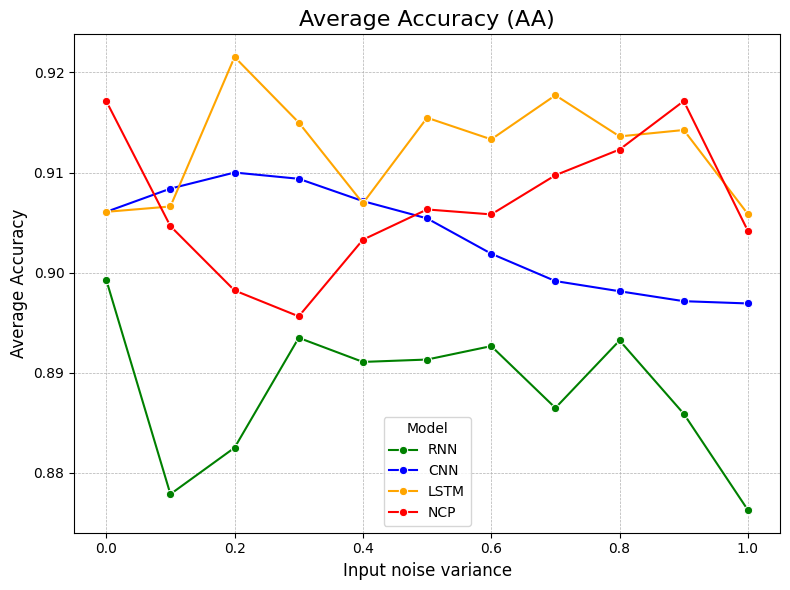

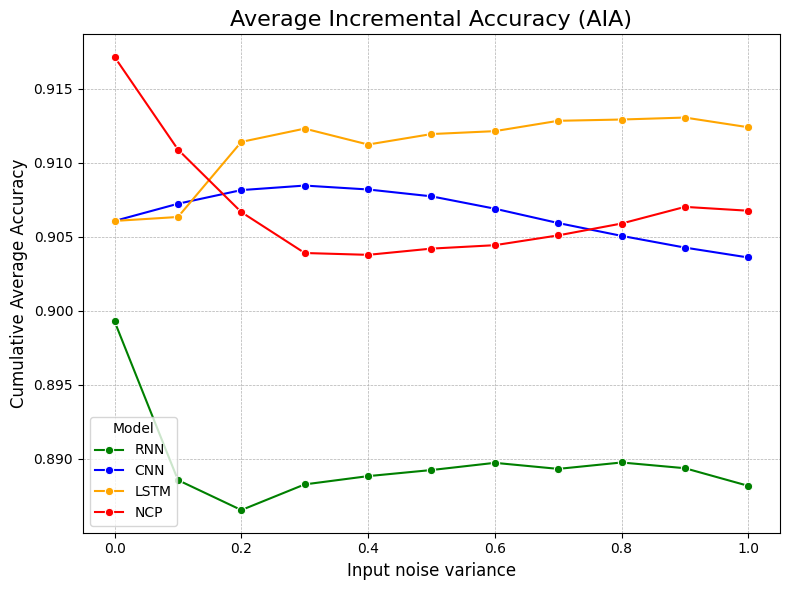

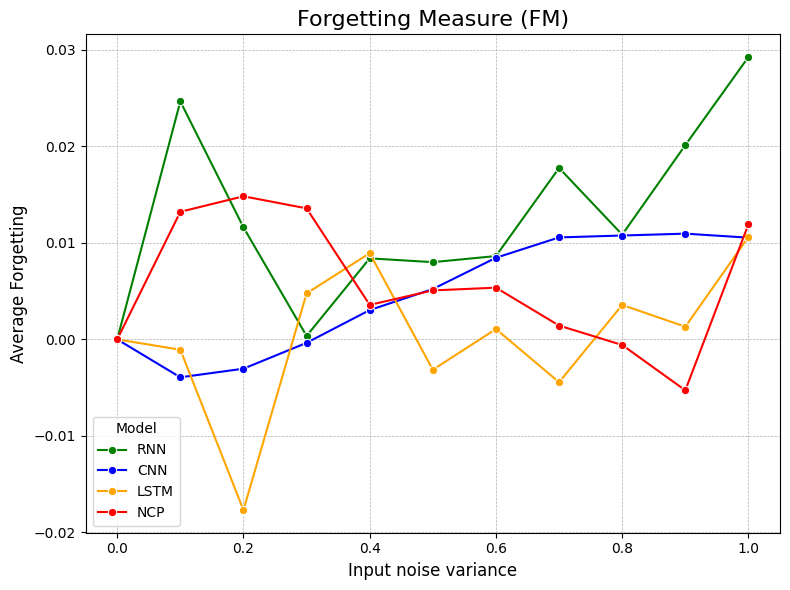

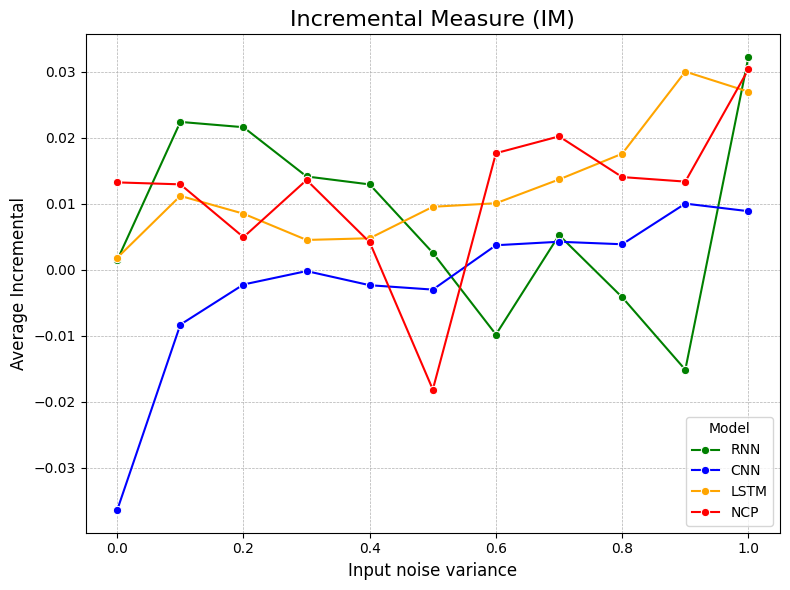

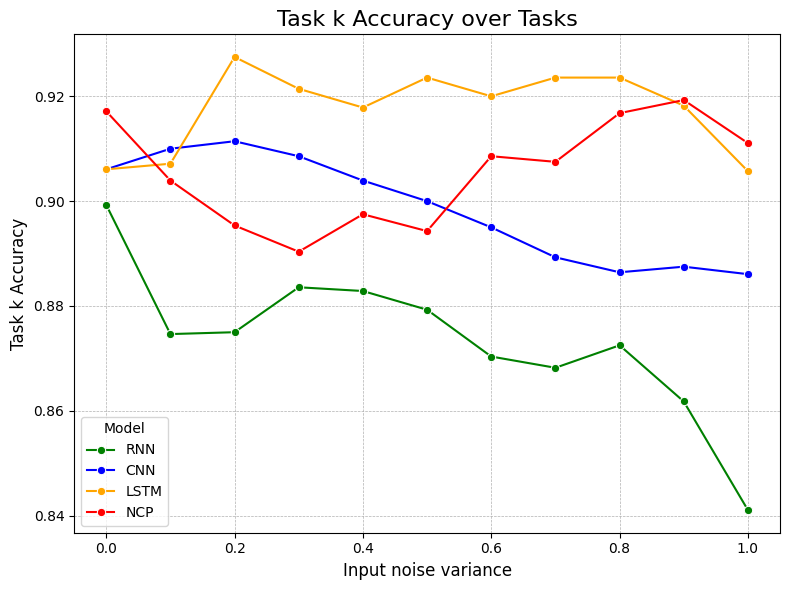

In [20]:

# --- AA ---
plt.figure(figsize=(8,6))
sns.lineplot(data=metrics_df, x="Noise", y="AA", hue="Model", palette=color_palette, marker="o")
plt.title("Average Accuracy (AA)", fontsize=16)
plt.xlabel("Input noise variance", fontsize=12)
plt.ylabel("Average Accuracy", fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# --- AIA ---
plt.figure(figsize=(8,6))
sns.lineplot(data=metrics_df, x="Noise", y="AIA", hue="Model", palette=color_palette, marker="o")
plt.title("Average Incremental Accuracy (AIA)", fontsize=16)
plt.xlabel("Input noise variance", fontsize=12)
plt.ylabel("Cumulative Average Accuracy", fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# --- FM ---
plt.figure(figsize=(8,6))
sns.lineplot(data=metrics_df, x="Noise", y="FM", hue="Model", palette=color_palette, marker="o")
plt.title("Forgetting Measure (FM)", fontsize=16)
plt.xlabel("Input noise variance", fontsize=12)
plt.ylabel("Average Forgetting", fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# --- IM ---
plt.figure(figsize=(8,6))
sns.lineplot(data=metrics_df, x="Noise", y="IM", hue="Model", palette=color_palette, marker="o")
plt.title("Incremental Measure (IM)", fontsize=16)
plt.xlabel("Input noise variance", fontsize=12)
plt.ylabel("Average Incremental", fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(title="Model")
plt.tight_layout()
plt.show()


# --- Task 0 Acc ---
plt.figure(figsize=(8,6))
sns.lineplot(data=metrics_df, x="Noise", y="Task 0 Acc", hue="Model", palette=color_palette, marker="o")
plt.title("Task k Accuracy over Tasks", fontsize=16)
plt.xlabel("Input noise variance", fontsize=12)
plt.ylabel("Task k Accuracy", fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(title="Model")
plt.tight_layout()
plt.show()